In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
tdc = pd.read_csv('data_sets/wr_tdc_new.csv')

In [3]:
columns_nonnum = ['cfb conference','cfb class']

In [4]:
columns_floats = list(range(13,21)) +list(range(26,53)) +list(range(60,73)) +list(range(75,83)) + [85,92,93]
tdc_floats = tdc.iloc[:,columns_floats]
tdcf = tdc_floats.corr(method='pearson')

# Metrics of Interest

In [5]:
(tdcf.abs().sum(axis = 1)/len(columns_floats)).sort_values(ascending = False)[0:5]

nfl touches                 0.457466
nfl yards from scrimmage    0.450265
nfl average grade           0.449970
nfl pass targets            0.447692
seasons above thresh        0.447459
dtype: float64

From simply looking at the correlation matrix, we search for targets that have the most (on average) correlation with the rest of the data. We also account for negative correlations by taking the absolute value. The result is 5 potential targets. We plot the correlation matrix as a heatmap, similarly that we did in the Exploratory_data notebook. We also look at the impact the nonnumerical factors have on our metrics

In [5]:
possible_targets = ['nfl touches','nfl yards from scrimmage',
                    'nfl average grade','nfl pass targets','seasons above thresh']

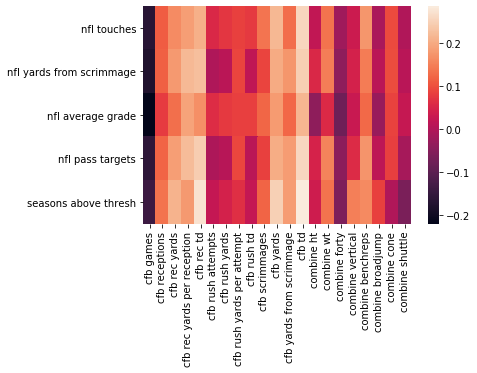

In [7]:
_ = sns.heatmap(tdcf.loc[possible_targets ,'cfb games':'combine shuttle'], annot=False)

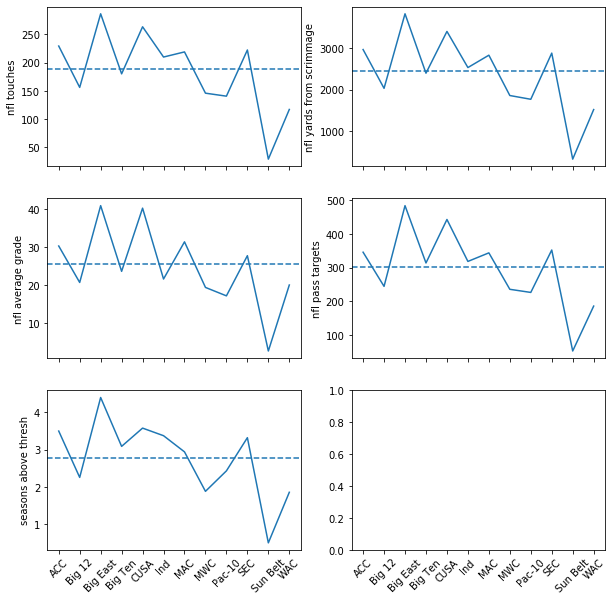

In [8]:
fig, axs = plt.subplots(3,2,figsize = (10,10), sharex=True, sharey=False)

(i,j) = (0,0)
k = 0
axs[i,j].plot(tdc.groupby(['cfb conference']).mean()[possible_targets[k]])
axs[i,j].set_ylabel(possible_targets[k])
axs[i,j].axhline(tdc[possible_targets[k]].mean(), linestyle = '--')

(i,j) = (0,1)
k = 1
axs[i,j].plot(tdc.groupby(['cfb conference']).mean()[possible_targets[k]])
axs[i,j].set(ylabel=possible_targets[k])
axs[i,j].axhline(tdc[possible_targets[k]].mean(), linestyle = '--')

(i,j) = (1,0)
k = 2
axs[i,j].plot(tdc.groupby(['cfb conference']).mean()[possible_targets[k]])
axs[i,j].set(ylabel=possible_targets[k])
axs[i,j].axhline(tdc[possible_targets[k]].mean(), linestyle = '--')

(i,j) = (1,1)
k = 3
axs[i,j].plot(tdc.groupby(['cfb conference']).mean()[possible_targets[k]])
axs[i,j].set(ylabel=possible_targets[k])
axs[i,j].axhline(tdc[possible_targets[k]].mean(), linestyle = '--')

(i,j) = (2,0)
k = 4
axs[i,j].plot(tdc.groupby(['cfb conference']).mean()[possible_targets[k]])
axs[i,j].set(ylabel=possible_targets[k])
axs[i,j].axhline(tdc[possible_targets[k]].mean(), linestyle = '--')

plt.setp(axs[2,0].get_xticklabels(), rotation=45)
plt.setp(axs[2,1].get_xticklabels(), rotation=45)
plt.show()

In [9]:
print('The means of our metrics are:\n',tdc[possible_targets].mean())

display(tdc.groupby(['cfb class'])[possible_targets].agg(['count','mean']))

The means of our metrics are:
 nfl touches                  187.919614
nfl yards from scrimmage    2444.768489
nfl average grade             25.608527
nfl pass targets             302.167702
seasons above thresh           2.768448
dtype: float64


nfl touches             nfl yards from scrimmage               \
                count        mean                    count         mean   
cfb class                                                                 
FR                  0         NaN                        0          NaN   
JR                 52  282.557692                       52  3825.269231   
SO                  8  479.125000                        8  6035.375000   
SR                192  162.807292                      192  2082.411458   

          nfl average grade            nfl pass targets              \
                      count       mean            count        mean   
cfb class                                                             
FR                        0        NaN                0         NaN   
JR                       52  33.634615               54  445.129630   
SO                        8  51.375000                8  791.500000   
SR                      157  22.242038              198  262.191919   

          seasons above thresh            
                         count      mean  
cfb class                                 
FR                           1  0.000000  
JR                          56  4.732143  
SO                           8  7.750000  
SR                         244  2.426230

# Running stat tests on target vs input

After narrowing down our study to a few targets, we will run statistical tests on our key inputs which we believe have an impact (positive or negative) on the target:
- 1) SEC vs Big 12
- 2) cfb games
- 3) cfb td
- 4) combine forty

### SEC vs Big 10

"Are there significant differences between subgroups in terms of explaining the answer to your project question"?

We suggest bootstrap

In [31]:
def bs_replicate_1d(array, func):
    return func(np.random.choice(array, len(array)))

def bootstraps(array, func, size):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bs_replicate_1d(array, func)
        
    return bs_replicates

i = 0
sec = tdc[tdc['cfb conference'] == 'SEC'][possible_targets[i]].fillna(0).values
big12 = tdc[tdc['cfb conference'] == 'Big 12'][possible_targets[i]].fillna(0).values

In [32]:
mean_diff = np.mean(sec) - np.mean(big12)
mean_diff, np.mean(sec), np.mean(big12)

(68.25187229010643, 177.135593220339, 108.88372093023256)

In [21]:
N_rep = 100

conc = np.concatenate((sec,big12))
mean_conc = np.mean(conc)

sec_shifted = sec - np.mean(sec) + mean_conc
big12_shift = big12 - np.mean(big12) + mean_conc

bs_rep_sec = bootstraps(sec_shifted, np.mean, N_rep)
bs_rep_big12 = bootstraps(big12_shift, np.mean, N_rep)

bs_rep_diff = bs_rep_sec - bs_rep_big12

sec

#p = np.sum(bs_rep_diff > mean_diff)/len(bs_rep_diff)
#print('The p-value of this test is :',p)

0      613.0
1      816.0
6      587.0
11      55.0
17     149.0
30     486.0
34     417.0
46     169.0
51       3.0
62     499.0
66     120.0
69     572.0
76     184.0
79       NaN
85       NaN
103    187.0
104    143.0
107    168.0
112     41.0
123    383.0
127      NaN
130    539.0
131    196.0
132     55.0
134    247.0
153     14.0
155      1.0
163     18.0
176      4.0
186      NaN
187     78.0
188     92.0
193     93.0
195    180.0
198    188.0
209      NaN
227    241.0
230    263.0
246      6.0
247      NaN
249      3.0
253      NaN
257     39.0
261    123.0
290    341.0
293    456.0
294    325.0
295     92.0
297    166.0
307     38.0
309      NaN
347    185.0
351      NaN
355      NaN
356     27.0
360    344.0
372    505.0
376      NaN
386      NaN
Name: nfl touches, dtype: float64

### CFB TD

plot the correlation between each metric and cfb td

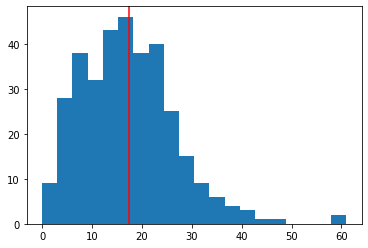

In [15]:
_ = plt.hist(tdc['cfb td'], bins = 20)
_ = plt.axvline(tdc['cfb td'].mean(), color = 'r')

,nfl pass targets,combine forty
nfl pass targets,1.000000,-0.040681
combine forty,-0.040681,1.000000


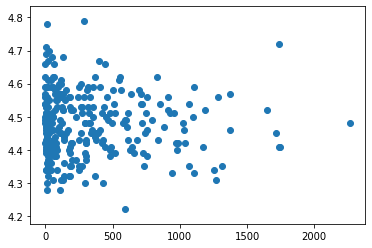

In [47]:
i = 3
covariance = tdc[[ possible_targets[i] ,'combine forty']].corr()
_ = plt.scatter(tdc[possible_targets[i]], tdc['combine forty'])
covariance